In [1]:
% Notebook for reproducing figures in Almansi et al. (submitted to JPO).
% This cell load the tools/variables and must be run every new session.

%----------------------------
% Define path containg tools
%----------------------------
toolspath = '../';

%---------------------------------------------------------------------------------------
% It takes several hours to download fields and create sections.
% You can skip this step by setting "use_mymatfiles = [0]".
% Otherwise, set "use_mymatfiles = [1]" and choose where you want to store the files.
%---------------------------------------------------------------------------------------
use_mymatfiles = [0];          % [0]: NO - [1]: yes
path_matfiles  = './matfiles'; % Only if  "use_mymatfiles = [1]". 

%----------------------------------------------------
% Redirect prints to logfile (only if "use_mymatfiles = [1]"):
% []: NO
% ['path/logfile']: YES
% You can monitor the logfile using the terminal:
% $ tail -f logfile
%----------------------------------------------------
logname = [];


%****************************************
%****************************************
% !!! DO NOT CHANGE AFTER THIS POINT !!!
%****************************************
%****************************************




% =============================================================================
% SET ENVIRONMENT:
% =============================================================================
if ~use_mymatfiles
    path_matfiles = '/home/idies/workspace/OceanCirculation/papers/Almansi_etal_2017';
end
%-----------------------------------------------------------------------
% Choose configuration:
% exp_ERAI: atmospheric forcing based on ERA-Interim
% exp_ASR:  atmospehric forcing based on ASR (Arctic System Reanalysis) 
%-----------------------------------------------------------------------
expname = 'exp_ERAI';

% ----------------------------------------------------------
% ¡DO NOT CHANGE!
% Add tools to search path
% ----------------------------------------------------------
% Choose 'sciserver' or 'datascope'
machine   = 'sciserver';
if strcmp(machine,'sciserver')
    % SciServer is shared with many other users:
    % keep the number of threads low!
    warning('off','MATLAB:maxNumCompThreads:Deprecated');
    maxNumCompThreads(1);
end
% Add path to search folder
funcspath  = [toolspath 'code'];
warning('off','MATLAB:dispatcher:nameConflict');
warning('off','MATLAB:rmpath:DirNotFound');
rmpath(genpath(funcspath))
addpath(genpath(funcspath))
% Set environment
run set_environment

if use_mymatfiles

% Create matfiles path
[status, msg, msgID] = mkdir([path_matfiles]);

% =============================================================================
% INFO
% =============================================================================

% Latrabjarg
Latrange_Latrab   = [  66.9  65.5]; % degN
Lonrange_Latrab   = [ -29.8 -24.6]; % degE
Depthrange_Latrab = [  0      700]; % m

% Trough
Latrange_Trough   = [  66.19   66.04 ]; % degN
Lonrange_Trough   = [ -27.17  -26.59 ]; % degE
Depthrange_Trough = [  0      700 ]; % m

% Cube
Latrange_Cube   = [  66.81 65.59]; % degN
Lonrange_Cube   = [ -29  -26 ]; % degE
Depthrange_Cube = [  0    1100 ]; % m

% Vector months
months_in_year = {'Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec'};
months_order   = [9:12 1:8];
MONTHS_string  = [];
for i = 1:length(months_order)
        month_numb = months_order(i);
        month_name = months_in_year{month_numb};
        if month_numb>=9
                year_numb = 2007;
        else
                year_numb = 2008;
        end
        year_name = num2str(year_numb);
        last_day  = sprintf('%02d',eomday(year_numb,month_numb));
        MONTHS_string{i} = {['01-' month_name '-' year_name ' 00'] [last_day '-' month_name '-' year_name ' 18']};
end
clear i last_day month_name month_numb months_in_year months_order year_name year_numb


% =============================================================================
% SAVE GRID
% =============================================================================
filename = [path_matfiles '/grid'];
fprintf('\n Saving to [%s]',filename);
save(filename,'grid','-v7.3')
fprintf('\n Saving to [%s]',filename);


% =============================================================================
% DOWLOAD FIELDS LATRABJARG
% =============================================================================

% -----------------------------------------------
% Plot map:
% [0]: NO
% [1]: YES
% ['path/figname']: save map (.eps) 
%------------------------------------------------
plotmap = [0];

% -----------------------------------------------
% Save fields to mat-file:
% []: NO
% ['path/matfile']: YES (.mat) 
%------------------------------------------------
savemat = [];

% -----------------------------------------------
% Plot mean fields:
% [0]: NO
% [1]: YES
% ['path/figname']: save mean plot (_Field.eps) 
%------------------------------------------------
plotmean = [0];

% -----------------------------------------------
% Create and save time-movie:
% []: NO
% ['path/moviename']: save movie (_Field.gif) 
%------------------------------------------------
savemovie = [];

% Loop through months to avoid size issues
for m = 1:length(MONTHS_string)

        % -------------------------------------------------------------------------------
        % Time information.
        % If deltaT=0, Time defines every single time to read.
        % Otherwise, deltaT defines the timestep and Time defines the timerange.
        % E.g. deltaT = 0; Time = {01-Jan-2008 00' '19-Mar-2008 00' '01-Aug-2008 00'}
        % E.g. deltaT = 0.25; Time = {01-Jan-2008 00' '01-Feb-2008 00'}
        % -------------------------------------------------------------------------------
        deltaT = [0.25]; % days
        Time   = MONTHS_string{m}; % 'dd-mmm-yyyy HH'
        fprintf('\n MONTH NUMBER: [%d]',month(Time{1},'dd-mmm-yyyy HH'));

        % ===============================================================================
        % READ AND PLOT VERTICAL SECTIONS:
        % Read vertical sections and interpolate fields to C-grid
        % This tool works with: VERTICAL SECTIONS like shipboard sections 
        %                       VERTICAL PROFILES like moorings
        %                       1-DEPTH STATIONS
        %                       1-DEPTH TRANSECTS
        % Lists of available fields are stored in ../info: info_exp_ASR.txt 
        %                                                  info_exp_ERAI.txt
        % Extra-fields (computed from MITgcm outputs): Sigma0 - Potential Density Anomaly
        %                                              N2     - Brunt-Väisälä frequency
        % ===============================================================================

        % ----------------------------------------------
        % Define transect:         
        % Select latitude, longitude and depth range       
        %              DEPTH1
        %           o----------o  
        % LAT1,LON1 |          |  LAT2,LON2
        %           o----------o  
        %              DEPTH2
        %-----------------------------------------------
        Latrange   = Latrange_Latrab; % degN   
        Lonrange   = Lonrange_Latrab; % degE   
        Depthrange = Depthrange_Latrab; % m

        % -------------------------------------------
        % Select fields using a cell array.
        % E.g.: {'Temp' 'S' 'Sigma0'}
        % -------------------------------------------
        Fields = {'Temp' 'S' 'Eta' 'Sigma0' 'N2'};

        % ---------------------------------------------------------
        % ¡DO NOT CHANGE!
        % Run code 
        % ---------------------------------------------------------
        option = 3;
        run run_eulerian_code

        % Cat files
        for f = 1:length(Fields)
                fld = Fields{f};
                if m==1
                        eval([fld '= VERTSECS.' fld ';']);
                else
                        eval([fld '.values' '=' 'cat(3,' fld '.values,' 'VERTSECS.' fld '.values);']);
                        eval([fld '.TIME'   '=' 'cat(1,' fld '.TIME,'   'VERTSECS.' fld '.TIME);'  ]);
                end
                if m==length(MONTHS_string)
                        filename = [path_matfiles '/' fld '_Latrabjarg'];
                        fprintf('\n Saving to [%s]',filename);
                        save(filename,fld)
                        if f==length(Fields)
                                fprintf('\n');
                        end
                end
        end
        % ===============================================================================
        % COMPUTE AND PLOT TRANSECT'S ORTHOGONAL/VERTICAL VELOCITIES:
        % Compute transect's orthogonal/tangent velocities (interpolated to C-grid)
        % This tool works with: VERTICAL SECTIONS like shipboard sections 
        %                       1-DEPTH TRANSECTS
        % Available fields: {'OrtVel' 'TanVel'}
        % ===============================================================================

        % ----------------------------------------------
        % Define transect:         
        % Select latitude, longitude and depth range       
        %              DEPTH1
        %           o----------o  
        % LAT1,LON1 |          |  LAT2,LON2
        %           o----------o  
        %              DEPTH2
        %-----------------------------------------------
        Latrange   = Latrange_Latrab; % degN   
        Lonrange   = Lonrange_Latrab; % degE   
        Depthrange = Depthrange_Latrab; % m

        % -------------------------------------------
        % Select fields using a cell array.
        % E.g.: {'OrtVel' 'TanVel'}
        % -------------------------------------------
        Fields = {'OrtVel' 'TanVel'};

        % ---------------------------------------------------------
        % ¡DO NOT CHANGE!
        % Run code 
        % ---------------------------------------------------------
        option = 4;
        run run_eulerian_code

        % Cat files
        for f = 1:length(Fields)
                fld = Fields{f};
                if m==1
                        eval([fld '= VSVEL.' fld ';']);
                else
                        eval([fld '.values' '=' 'cat(3,' fld '.values,' 'VSVEL.' fld '.values);']);
                        eval([fld '.TIME'   '=' 'cat(1,' fld '.TIME,'   'VSVEL.' fld '.TIME);'  ]);
                end
                if m==length(MONTHS_string)
                        filename = [path_matfiles '/' fld '_Latrabjarg'];
                        fprintf('\n Saving to [%s]',filename);
                        save(filename,fld)
                        if f==length(Fields)
                                fprintf('\n');
                        end
                end
        end

        % ===============================================================================
        % COMPUTE AND PLOT TRANSPORT THROUGH A VERTICAL SECTION.
        % Compute transport through a vertical section,
        % using temperature, salinity and/or density limits.
        % ===============================================================================

        % ----------------------------------------------
        % Define transect:         
        % Select latitude, longitude and depth range       
        %              DEPTH1
        %           o----------o  
        % LAT1,LON1 |          |  LAT2,LON2
        %           o----------o  
        %              DEPTH2
        %-----------------------------------------------
        Latrange   = Latrange_Trough; % degN   
        Lonrange   = Lonrange_Trough; % degE   
        Depthrange = Depthrange_Trough; % m

        % Define temperature, salinity and density limits
        % ===============================================================================

        % ----------------------------------------------
        % Define transect:         
        % Select latitude, longitude and depth range       
        %              DEPTH1
        %           o----------o  
        % LAT1,LON1 |          |  LAT2,LON2
        %           o----------o  
        %              DEPTH2
        %-----------------------------------------------
        Latrange   = Latrange_Trough; % degN   
        Lonrange   = Lonrange_Trough; % degE   
        Depthrange = Depthrange_Trough; % m

        % Define temperature, salinity and density limits
        % First(second) value defines lower(upper) limit.
        % E.g. Sigma0range = {[27.8] []}: 
        %      Transport of water denser than 27.8 kg/m^3
        % E.g  Temprange   = {[0] [2]}
        %      Transport of water between 0 and 2°C
        %------------------------------------------------
        Temprange   = {[    ] [    ]}; % °C 
        Srange      = {[    ] [    ]}; % 
        Sigma0range = {[27.8] [    ]}; % kg/m^3 

        % -----------------------------------------------
        % Define temperature, salinity and density limits
        % Consider inflow (+), outflow(-) or both:
        % [-1]: Outflow (negative velocities)
        % [  ]: Both
        % [+1]: Inflow (positive velocities)
        % -----------------------------------------------
        InOutFlow = [];

        % -----------------------------------------------
        % Plot transport timeseries:
        % [0]: NO
        % [1]: YES
        % ['path/figname']: save mean plot (_Field.eps) 
        %------------------------------------------------
        plottransp = [0];

        % ---------------------------------------------------------
        % ¡DO NOT CHANGE!
        % Run code 
        % ---------------------------------------------------------
        option = 5;
        run run_eulerian_code

        % Cat files
        if m==1
                Transport = TRANSPORT;
        else
                Transport.values = cat(1,Transport.values,TRANSPORT.values);
                Transport.cross_sectional_area = cat(1,Transport.cross_sectional_area,TRANSPORT.cross_sectional_area);
                Transport.TIME   = cat(1,Transport.TIME,TRANSPORT.TIME);
        end
        if m==length(MONTHS_string)
                filename = [path_matfiles '/Transport_Trough'];
                fprintf('\n Saving to [%s]',filename);
                save(filename,'Transport')
                fprintf('\n Saving to [%s]',filename);
        end
        
        % ===============================================================================
        % READ FIELDS:
        % Read MITgcm outputs. 
        % Lists of available fields are stored in ../info: info_exp_ASR.txt 
        %                                                  info_exp_ERAI.txt
        % Extra-fields (computed from MITgcm outputs): Sigma0 - Potential Density Anomaly
        %                                              N2     - Brunt-Väisälä frequency
        % ===============================================================================

        % -------------------------------------------
        % Select fields using a cell array.
        % E.g.: {'Temp' 'S' 'Sigma0'}
        % -------------------------------------------
        Fields = {'Eta' 'Sigma0'};

        % ----------------------------------------------
        % Cutoff: 
        % Select latitude, longitude and depth range
        %                  LAT1
        %              o----------o       
        %       LON1  /          /| LON2
        %            /    LAT2  / | 
        %    DEPTH1 o----------o  o
        %           |          | / 
        %    DEPTH2 o----------o  
        %              
        %-----------------------------------------------
        Latrange   = Latrange_Cube; % degN
        Lonrange   = Lonrange_Cube; % degE
        Depthrange = Depthrange_Cube; % m

        % -----------------------------------------------
        % Interpolate fields to C-grid. 
        % [0]: NO
        % [1]: YES
        %------------------------------------------------
        interpC = [0];

        % ---------------------------------------------------------
        % ¡DO NOT CHANGE!
        % Run code 
        % ---------------------------------------------------------
        option = 2;
        run run_eulerian_code

        % Cat files
        for f = 1:length(Fields)
                fld = Fields{f};
                if m==1
                        eval([fld '_Cube = FIELDS.' fld ';']);
                else
                        eval([fld '_Cube.values' '=' 'cat(4,' fld '_Cube.values,' 'FIELDS.' fld '.values);']);
                        eval([fld '_Cube.TIME'   '=' 'cat(1,' fld '_Cube.TIME,'   'FIELDS.' fld '.TIME);'  ]);
                end
                if m==length(MONTHS_string)
                        filename = [path_matfiles '/' fld '_Cube'];
                        fprintf('\n Saving to [%s]',filename);
                        save(filename,[fld '_Cube'],'-v7.3')
                        if f==length(Fields)
                                fprintf('\n');
                        end
                end
        end
end % Loop months
end % use_mymatfiles

-------------------------------------------------------
 Welcome to the SciServer Ocean Modelling User Case!
-------------------------------------------------------

 Reading grid variables: done in 16.375797 seconds


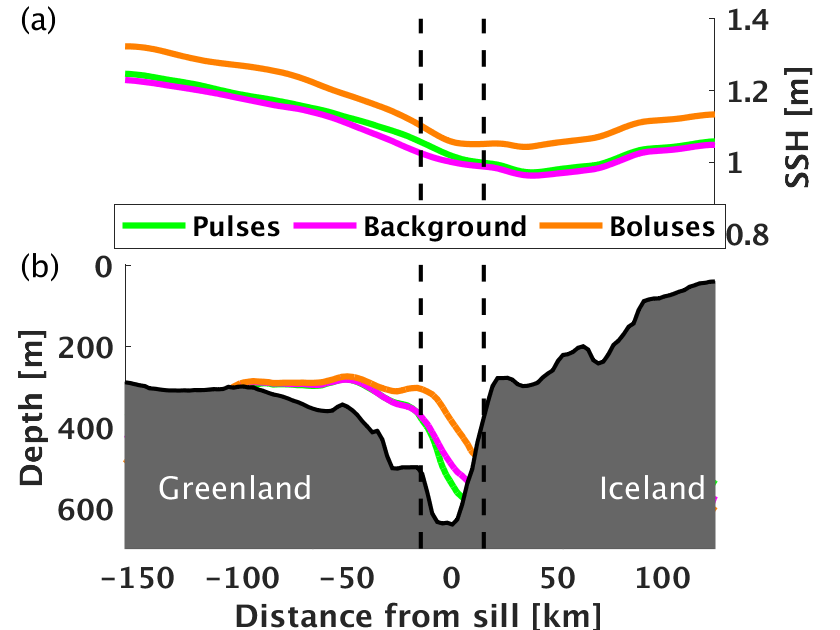

In [2]:
% Figure 02
% ===================================================================================================
% Composites of (a) Sea Surface Height and (b) DSO interface during boluses (orange), 
% pulses (green), and background state (magenta). 
% Black dashed lines bound the region from 15~km west to 15~km east of the deepest part of the sill. 
% Negative (positive) distances correspond to northwest (southeast) of the sill. 
% The viewer is looking to the north.
% ===================================================================================================

% Housekeeping
clearvars -except path_matfiles

% Load fields and mask
load([path_matfiles '/mask_BolPol'])
load([path_matfiles '/Sigma0_Latrabjarg.mat'])
load([path_matfiles '/Eta_Latrabjarg.mat'])

% Create dimensions
X           = Sigma0.DIST;
Y           = Sigma0.DEPTH;

% Move 0 to sill
bathy       = Sigma0.bathy;
[~,indsill] = max(bathy);
X = X - X(indsill);

% Create composites
Eta_bol     = squeeze(nanmean(Eta.values(:,:,msk_Bol),3));
Eta_pul     = squeeze(nanmean(Eta.values(:,:,msk_Pul),3));
Eta_bgd     = squeeze(nanmean(Eta.values(:,:,msk_Bgd),3));
Sigma0_bol  = squeeze(nanmean(Sigma0.values(:,:,msk_Bol),3));
Sigma0_pul  = squeeze(nanmean(Sigma0.values(:,:,msk_Pul),3));
Sigma0_bgd  = squeeze(nanmean(Sigma0.values(:,:,msk_Bgd),3));

% Figure
fig = figure();
subpos = [0.15 0.63 0.7 0.34 ;
          0.15 0.13 0.7 0.45];
set(fig,'Position',[0 0 560 420]./1.e2)
set(0,'DefaultAxesFontSize',14)
colpul = [0 1 0];
colbol = [1 0.5 0];

% Subplots
for i = 1:size(subpos,1)
        subplot('Position',subpos(i,:))
        hold on

        if i==1
                ylims = [0.8 1.4];
                hold on
                plot(X,Eta_pul,'Color',colpul,'LineWidth',3)
                plot(X,Eta_bgd,'m','LineWidth',3)
                plot(X,Eta_bol,'Color',colbol,'LineWidth',3)
                lg = legend('Pulses','Background','Boluses','Orientation','horizontal','Location','Best');
                set(lg,'Position',[0.15 0.6 0.7 0.08])
                plot([-15 -15],[ylims],'k--','LineWidth',2);
                plot([ 15  15],[ylims],'k--','LineWidth',2);
                ylim(ylims)
                set(gca,'Xtick',[]);
                set(gca,'Ytick',[0.8:0.2:1.4]);
                set(gca,'YAxisLocation','right')
                ylabel('SSH [m]','FontWeight','bold')
                text(X(1)-50,1.4,['(' char('a'+i-1) ')'],'FontSize',15)
        elseif i==2
                ylims = [-0.8,700];
                % Bathymetry
                x1 = X';
                y1 = bathy';
                x2 = x1;
                y2 = repmat(700,size(x2));
                contour(X,Y,inpaint_nans(Sigma0_pul'),[27.8 27.8],'Color',colpul,'LineWidth',3)
                contour(X,Y,inpaint_nans(Sigma0_bgd'),[27.8 27.8],'m','LineWidth',3)
                contour(X,Y,inpaint_nans(Sigma0_bol'),[27.8 27.8],'Color',colbol,'LineWidth',3)
                fill([x1,fliplr(x2)],[y1,fliplr(y2)],[0.4 0.4 0.4],'edgecolor',[0.4 0.4 0.4]);
                plot(x1,y1,'k-','LineWidth',2);
                set(gca,'Ydir','reverse')
                set(gca,'YAxisLocation','left')
                ylim(ylims)
                xlabel('Distance from sill [km]','FontWeight','bold')
                ylabel('Depth [m]','FontWeight','bold')
                text(X(1)-50,0,['(' char('a'+i-1) ')'],'FontSize',15)
                text(-140,550,'Greenland','FontSize',15,'Color','White')
                text(70,550,'Iceland','FontSize',15,'Color','White')
                plot([-15 -15],[ylims],'k--','LineWidth',2);
                plot([ 15  15],[ylims],'k--','LineWidth',2);
        end
        xlim([min(X) max(X)])
end


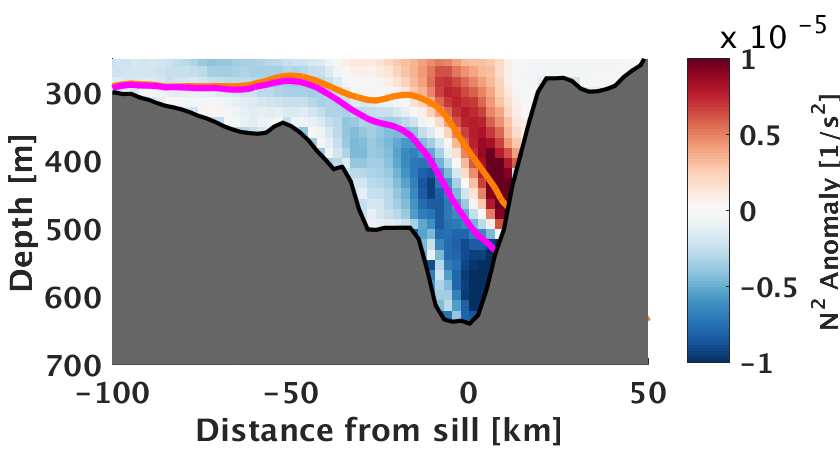

In [3]:
% Figure 03
% ===================================================================================================
% Composite of boluses minus background state Brunt-Vaisala frequency. 
% The orange (magenta) line corresponds to the composite of boluses (background state) DSO interface.
% ====================================================================================================

% Housekeeping
clearvars -except path_matfiles

% Load fields and mask
load([path_matfiles '/mask_BolPol'])
load([path_matfiles '/Sigma0_Latrabjarg.mat'])
load([path_matfiles '/N2_Latrabjarg.mat'])

% Create dimensions
X           = Sigma0.DIST;
Y           = Sigma0.DEPTH;

% Move 0 to sill
bathy       = Sigma0.bathy;
[~,indsill] = max(bathy);
X = X - X(indsill);

% Create composites
N2_bol     = squeeze(nanmean(N2.values(:,:,msk_Bol),3));
N2_bgd     = squeeze(nanmean(N2.values(:,:,msk_Bgd),3));
Sigma0_bol  = squeeze(nanmean(Sigma0.values(:,:,msk_Bol),3));
Sigma0_bgd  = squeeze(nanmean(Sigma0.values(:,:,msk_Bgd),3));

% Figure
fig = figure();
set(fig,'Position',[0 0 560 300]./1.e2)
set(fig,'renderer','painters')
hold on
set(0,'DefaultAxesFontSize',15)
colormap(flipud(othercolor('RdBu11',100)));
colpul = [0 1 0];
colbol = [1 0.5 0];

% pcolor
Z = inpaint_nans(N2_bol - N2_bgd);
pcolor(X,Y,Z');
shading flat
caxis([-1 1].*1e-5);
colbh = colorbar();

% OW interface
contour(X,Y,inpaint_nans(Sigma0_bol'),[27.8 27.8],'Color',colbol,'LineWidth',3)
contour(X,Y,inpaint_nans(Sigma0_bgd'),[27.8 27.8],'m-','LineWidth',3)

% Bathymetry
x1 = X';
y1 = bathy';
x2 = x1;
y2 = repmat(700,size(x2));
fill([x1,fliplr(x2)],[y1,fliplr(y2)],[0.4 0.4 0.4],'edgecolor',[0.4 0.4 0.4]);
plot(x1,y1,'k-','LineWidth',2);

% Axis
ylabel(colbh,'N^2 Anomaly [1/s^2]','FontWeight','bold')
xlabel('Distance from sill [km]','FontWeight','bold')
ylabel('Depth [m]','FontWeight','bold')
set(gca,'Ydir','reverse')
xlim([-100 50])
ylim([250 700])
daspect([0.19 1 1])

% Move exponential
YTL = get(colbh,'YTickLabel');
set(colbh,'YTickLabel','');
NewText = 'x 10 ^{-5}';
set(colbh,'YTickLabel',YTL);
text(70,210,NewText,'FontSize',15)


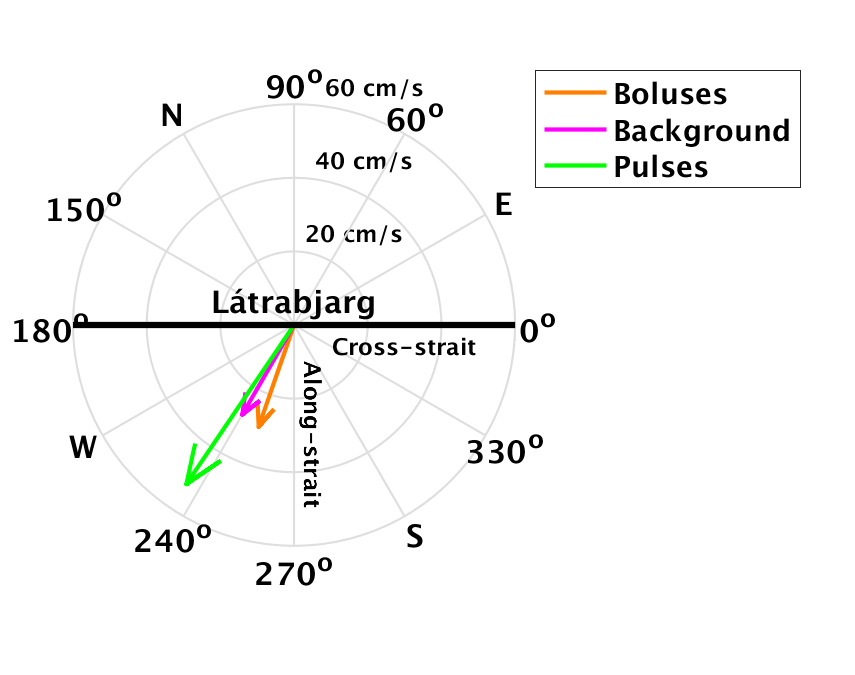

Along-strait direction:
       Boluses: -0.276430
       Pulses: -0.432071
       Background: -0.243121

 Cross-strait direction:
       Boluses: -0.095964
       Pulses: -0.292299
       Background: -0.140554

 Cross-stream direction:
       Boluses: -109.144689
       Pulses: -124.078621
       Background: -120.033299


In [4]:
% Figure 07
% ========================================================================================
% Mean velocity of the DSO between 15 km west and 15 km east of the sill 
% in the composites of boluses (orange), pulses (green), and background state (magenta). 
% The black bold line corresponds to the direction of the Latrabjarg line (cross-strait).
% ========================================================================================

% Housekeeping
clearvars -except path_matfiles

% Load fields and mask
load([path_matfiles '/mask_BolPol'])
load([path_matfiles '/OrtVel_Latrabjarg.mat'])
load([path_matfiles '/TanVel_Latrabjarg.mat'])
load([path_matfiles '/Sigma0_Latrabjarg.mat'])

% Move 0 to sill
DIST = Sigma0.DIST;
bathy = Sigma0.bathy;
[~,indsill] = max(bathy);
DIST = DIST - DIST(indsill);

% Create composites in the trough
dst1 = -15; dst2 = 15;
OrtVel_bol  = squeeze(nanmean(OrtVel.values(DIST>dst1 & DIST<dst2,:,msk_Bol),3));
OrtVel_pul  = squeeze(nanmean(OrtVel.values(DIST>dst1 & DIST<dst2,:,msk_Pul),3));
OrtVel_bgd  = squeeze(nanmean(OrtVel.values(DIST>dst1 & DIST<dst2,:,msk_Bgd),3));
TanVel_bol  = squeeze(nanmean(TanVel.values(DIST>dst1 & DIST<dst2,:,msk_Bol),3));
TanVel_pul  = squeeze(nanmean(TanVel.values(DIST>dst1 & DIST<dst2,:,msk_Pul),3));
TanVel_bgd  = squeeze(nanmean(TanVel.values(DIST>dst1 & DIST<dst2,:,msk_Bgd),3));
Sigma0_bol  = squeeze(nanmean(Sigma0.values(DIST>dst1 & DIST<dst2,:,msk_Bol),3));
Sigma0_pul  = squeeze(nanmean(Sigma0.values(DIST>dst1 & DIST<dst2,:,msk_Pul),3));
Sigma0_bgd  = squeeze(nanmean(Sigma0.values(DIST>dst1 & DIST<dst2,:,msk_Bgd),3));

% Mask DSO
OrtVel_bol(Sigma0_bol<27.8) = NaN;
OrtVel_pul(Sigma0_pul<27.8) = NaN;
OrtVel_bgd(Sigma0_bgd<27.8) = NaN;
TanVel_bol(Sigma0_bol<27.8) = NaN;
TanVel_pul(Sigma0_pul<27.8) = NaN;
TanVel_bgd(Sigma0_bgd<27.8) = NaN;

% Compute mean velocities
OrtVel_bol = nanmean(OrtVel_bol(:));
OrtVel_pul = nanmean(OrtVel_pul(:));
OrtVel_bgd = nanmean(OrtVel_bgd(:));
TanVel_bol = nanmean(TanVel_bol(:));
TanVel_pul = nanmean(TanVel_pul(:));
TanVel_bgd = nanmean(TanVel_bgd(:));

fprintf('\n Along-strait direction:')
fprintf('\n       Boluses: %f',OrtVel_bol)
fprintf('\n       Pulses: %f',OrtVel_pul)
fprintf('\n       Background: %f',OrtVel_bgd)
fprintf('\n')

fprintf('\n Cross-strait direction:')
fprintf('\n       Boluses: %f',TanVel_bol)
fprintf('\n       Pulses: %f',TanVel_pul)
fprintf('\n       Background: %f',TanVel_bgd)
fprintf('\n')

% Find angle of cross-stream velocity
% and create velocity vectors
dir_bol = atan2d(OrtVel_bol,TanVel_bol);
dir_bgd = atan2d(OrtVel_bgd,TanVel_bgd);
dir_pul = atan2d(OrtVel_pul,TanVel_pul);
U  = [TanVel_bol TanVel_bgd TanVel_pul]';
V  = [OrtVel_bol OrtVel_bgd OrtVel_pul]';
fprintf('\n Cross-stream direction:')
fprintf('\n       Boluses: %f',dir_bol)
fprintf('\n       Pulses: %f',dir_pul)
fprintf('\n       Background: %f',dir_bgd)
fprintf('\n')

% Figure
fig = figure();
set(fig,'Position',[0 0 570 450]./1.e2)
set(0,'DefaultAxesFontSize',15)
colpul = [0 1 0];
colbol = [1 0.5 0];

% Polar plot
h  = compass(U*1.e2,V*1.e2);

% Fix colors
for i = 1:3
        h(i).LineWidth = 2;
        switch i
                case 1
                        col = colbol;
                case 2
                        col = 'm';
                case 3
                        col = colpul;
        end
        h(i).Color = col;
end
legend('Boluses','Background','Pulses','Location','bestoutside')

% Label Axis
TXT = findall(gca,'type','text');
TXT(1).String='0^o';
TXT(2).String='180^o';
TXT(3).String='330^o';
TXT(4).String='150^o';
TXT(6).String = 'N';
TXT(6).FontWeight = 'bold';
TXT(5).String = 'S';
TXT(5).FontWeight = 'bold';
TXT(7).String='270^o';
TXT(8).String='90^o';
TXT(9).String='240^o';
TXT(10).String='60^o';
TXT(12).String = 'E';
TXT(12).FontWeight = 'bold';
TXT(11).String = 'W';
TXT(11).FontWeight = 'bold';
TXT(13).String = '60 cm/s';
TXT(13).FontSize = 11;
TXT(14).String = '40 cm/s';
TXT(14).FontSize = 11;
TXT(15).String = '20 cm/s';
TXT(15).FontSize = 11;

% Plot Latrabjarg line direction
hold on
plot([-180 180],[0 0],'k','LineWidth',3)
text(0,1,'Látrabjarg','FontSize',15,'FontWeight','bold','Color','k','VerticalAlignment','bottom','HorizontalAlignment','center');

% Along and Cross-strait labels
text(1,-30,'Along-strait','FontSize',11,'FontWeight','bold','Color','k','VerticalAlignment','bottom','HorizontalAlignment','center','rotation',90+180);
text(30,-2,'Cross-strait','FontSize',11,'FontWeight','bold','Color','k','VerticalAlignment','top','HorizontalAlignment','center');



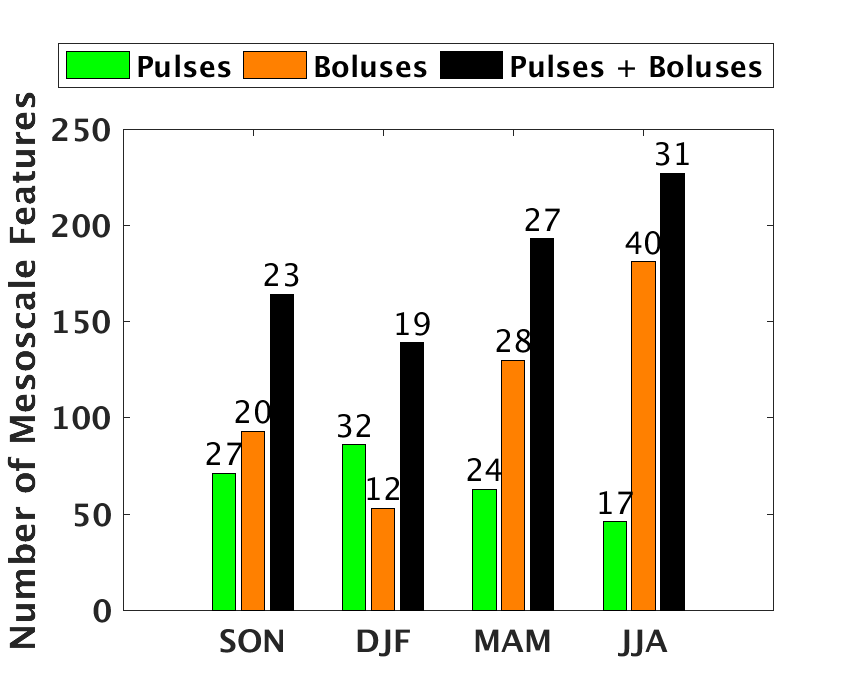

In [5]:
% Figure 08
% =========================================================================
% Seasonality of boluses and pulses. 
% Green (orange) bars show the number of pulses (boluses) in a season. 
% Black bars show the seasonal distribution of boluses + pulses. 
% The numbers on the top of the bars indicate the percentage of 
% boluses, pulses, or boluses+pulses in a season compared to 
% the total number of boluses, pulses, or boluses+pulses, respectively.
% The three-month acronyms for seasons are: DJF, MAM, JJA, SON.
% =========================================================================

% Housekeeping
clearvars -except path_matfiles

% Load mask
load([path_matfiles '/mask_BolPol'])

% Convert time in months
months_bol = month(time(msk_Bol));
months_pul = month(time(msk_Pul));

% Create bins
bins = [sum(months_pul==9 | months_pul==10 | months_pul==11) sum(months_bol==9 | months_bol==10 | months_bol==11);
        sum(months_pul==12 | months_pul==1 | months_pul==2) sum(months_bol==12 | months_bol==1 | months_bol==2);
        sum(months_pul==3 | months_pul==4 | months_pul==5) sum(months_bol==3 | months_bol==4 | months_bol==5);
        sum(months_pul==6 | months_pul==7 | months_pul==8) sum(months_bol==6 | months_bol==7 | months_bol==8)];
bins(:,3) = bins(:,1)+bins(:,2);

% Compute percentage
perc = zeros(size(bins));
perc(:,1) = 100*bins(:,1)/length(months_pul);
perc(:,2) = 100*bins(:,2)/length(months_bol);
perc(:,3) = 100*bins(:,3)/(length(months_pul)+length(months_bol));

% Figure
fig = figure();
set(fig,'Position',[0 0 570 450]./1.e2)
set(0,'DefaultAxesFontSize',15)
colpul = [0 1 0];
colbol = [1 0.5 0];

% Plot bars 
b = bar(bins);
set(b(1),'FaceColor',colpul)
set(b(2),'FaceColor',colbol)
set(b(3),'FaceColor','k')
set(gca,'XTickLabel',{'SON' 'DJF' 'MAM' 'JJA'})
legend('Pulses','Boluses','Pulses + Boluses','Location','northoutside','Orientation','horizontal')
ylabel('Number of Mesoscale Features','FontWeight','bold')

% Write percentages 
for ib = 1:numel(b)
    xvals(ib,:) = b(ib).XData+b(ib).XOffset;
end
BINS = bins';
PERC = round(perc');
BINS = BINS(:);
PERC = PERC(:);
xvals = xvals(:);
for i = 1: length(xvals)
        text(xvals(i),BINS(i),num2str(PERC(i)),...
        'Vert','bot','horiz','cen','FontSize',15);
end


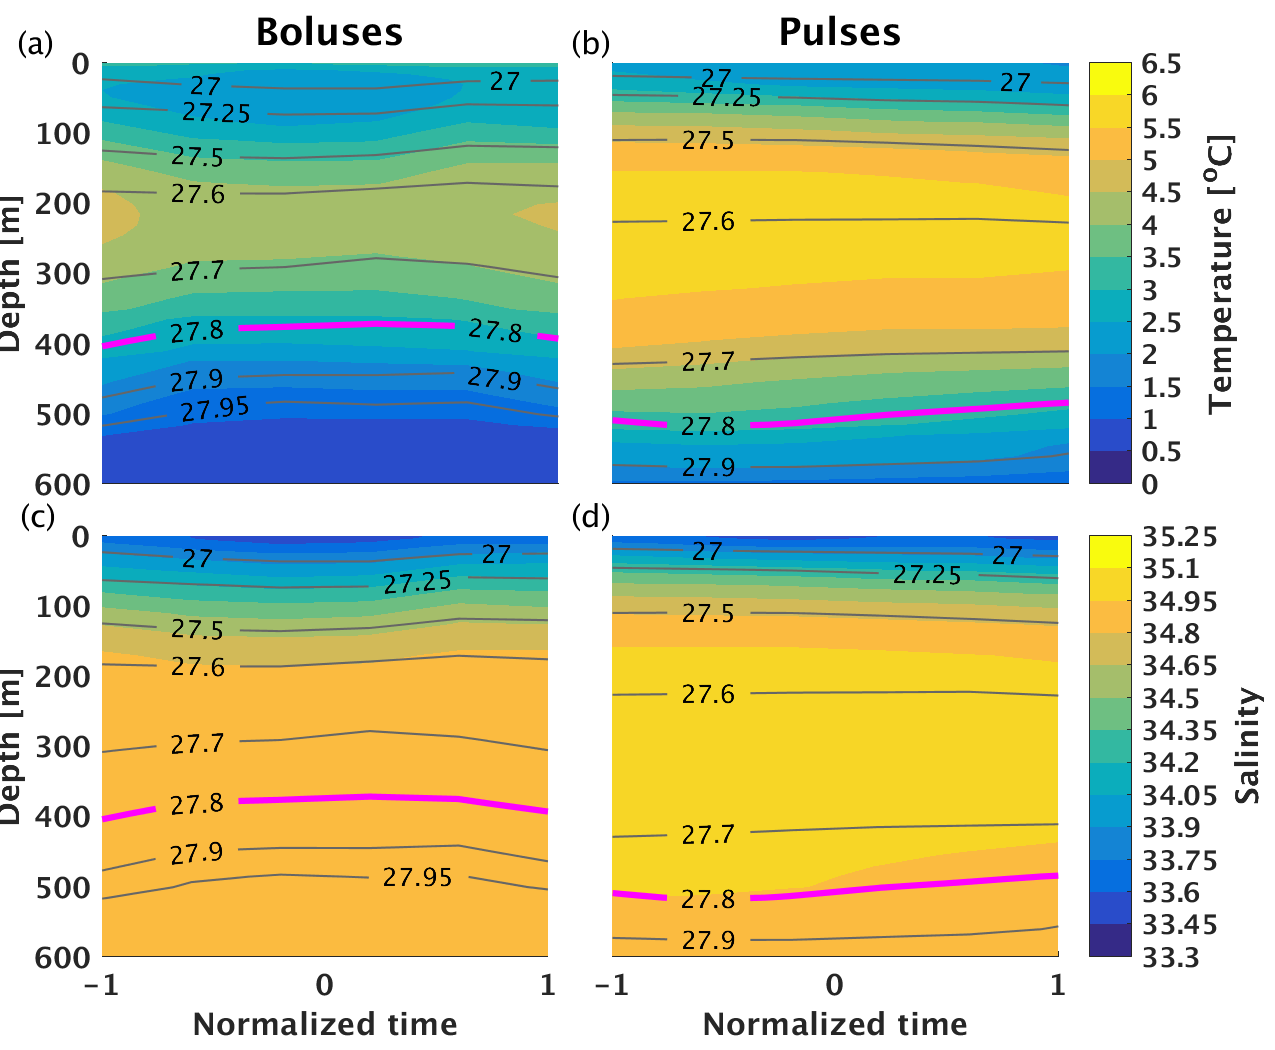

Number of boluses in the composite: 13
 Number of pulses in the composite: 12


In [6]:
% Figure 09
% ==================================================================================================
% Time evolution of the composites of representative boluses (left column) 
% and pulses (right column) obtained by averaging (a and b) potential temperature, 
% and (c and d) salinity over the area between 15~km west and 15~km east of the sill. 
% The time axis is normalized to the length of the events 
% (57.1+/-10 hours for boluses and 27.5+/-15.4 hours for pulses). 
% The potential density contours are drawn in gray and the DSO interface is highlighted in magenta.
% ==================================================================================================

% Housekeeping
clearvars -except path_matfiles

% Load mask
load([path_matfiles '/mask_BolPol'])
load([path_matfiles '/Temp_Latrabjarg.mat'])
load([path_matfiles '/S_Latrabjarg.mat'])
load([path_matfiles '/Sigma0_Latrabjarg.mat'])
load([path_matfiles '/OrtVel_Latrabjarg'])

% Grid info
DIST   = Sigma0.DIST;
TIME   = Sigma0.TIME;
DEPTH  = Sigma0.DEPTH;
bathy  = Sigma0.bathy;

% Move 0 to sill
[~,indsill] = max(bathy);
DIST = DIST - DIST(indsill);

% Average between -15 15km
dst1 = -15; dst2 = 15;
Sigma0 = squeeze(nanmean(Sigma0.values(DIST>dst1 & DIST<dst2,:,:),1));
Temp   = squeeze(nanmean(Temp.values(DIST>dst1 & DIST<dst2,:,:),1));
Salt   = squeeze(nanmean(S.values(DIST>dst1 & DIST<dst2,:,:),1));
OrtVel = squeeze(nanmean(OrtVel.values(DIST>dst1 & DIST<dst2,:,:),1));

% Normalized time
k = 2; newtime = linspace(-1,1,3*k);

% -------------------------------------
% Create composite of boluses
Sigma0_comp = [];
Temp_comp   = [];
Salt_comp   = [];

% Exclude boluses too long/short
LIM1 = 8; LIM2 = 11;
suminds = inds_Bol(:,2)-inds_Bol(:,1);
inds_Bol(suminds<LIM1 | suminds>LIM2,:) = [];
for i = 1:size(inds_Bol,1)

        thisinds = inds_Bol(i,1):inds_Bol(i,2);
        thistime = TIME(thisinds);
        dt       = thistime(end) - thistime(1);
        thistime = (thistime - thistime(1) - dt/2);
        thistime = thistime/max(thistime);

        sigma0  = Sigma0(:,thisinds);
        temp    = Temp(:,thisinds);
        salt    = Salt(:,thisinds);

        newsigma0 = interp2(DEPTH,thistime,sigma0',DEPTH,newtime);
        newtemp   = interp2(DEPTH,thistime,temp',DEPTH,newtime);
        newsalt   = interp2(DEPTH,thistime,salt',DEPTH,newtime);

        Sigma0_comp(:,:,i) = newsigma0;
        Temp_comp(:,:,i)   = newtemp;
        Salt_comp(:,:,i)   = newsalt;
end
fprintf('\n Number of boluses in the composite: %d',size(inds_Bol,1));
Sigma0_bol = nanmean(Sigma0_comp,3);
Temp_bol   = nanmean(Temp_comp,3);
Salt_bol   = nanmean(Salt_comp,3);

% -------------------------------------
% Create composite of pulses
Sigma0_comp = [];
Temp_comp   = [];
Salt_comp   = [];
OrtVel_comp = [];

count = 0;
for i = 1:size(inds_Pul,1)
        thisinds = inds_Pul(i,1):inds_Pul(i,2);
        thistime = TIME(thisinds);
        dt       = thistime(end) - thistime(1);
        thistime  = (thistime - thistime(1) - dt/2);
        thistime  = thistime/max(thistime);

        sigma0  = Sigma0(:,thisinds);
        temp    = Temp(:,thisinds);
        salt    = Salt(:,thisinds);
        ortvel  = OrtVel(:,thisinds);

        newsigma0 = interp2(DEPTH,thistime,sigma0',DEPTH,newtime);
        newtemp   = interp2(DEPTH,thistime,temp',DEPTH,newtime);
        newsalt   = interp2(DEPTH,thistime,salt',DEPTH,newtime);
        newortvel = interp2(DEPTH,thistime,ortvel',DEPTH,newtime);

        indDEPTH = min(find(DEPTH>550));
        thisnewortvel = nanmean(newortvel(:,indDEPTH:end),2);
        thisnewsigma0 = nanmean(newsigma0(:,indDEPTH:end),2);

        % Consider only symmetric pulses
        if mean(thisnewortvel(1:k))>mean(thisnewortvel(k+1:2*k)) & mean(thisnewortvel(2*k+1:end))>mean(thisnewortvel(k+1:2*k))
                count = count+1;
                Sigma0_comp(:,:,count) = newsigma0;
                Temp_comp(:,:,count)   = newtemp;
                Salt_comp(:,:,count)   = newsalt;
                OrtVel_comp(:,:,count) = newortvel;
        end
end
fprintf('\n Number of pulses in the composite: %d\n',count);
Sigma0_pul = nanmean(Sigma0_comp,3);
Temp_pul   = nanmean(Temp_comp,3);
Salt_pul   = nanmean(Salt_comp,3);
OrtVel_pul = nanmean(OrtVel_comp,3);

% Figure
fig    = figure();
set(fig,'Position', [0, 0, 850, 700]./1.e2)
set(0,'DefaultAxesFontSize',14)
positionSubplot = [0.08  0.54  0.44 0.4 ;
                   0.48  0.54  0.44 0.4 ;
                   0.08  0.09  0.44 0.4 ;
                   0.48  0.09  0.44 0.4];
% Subplots
X = newtime;
Y = DEPTH;
for i=1:size(positionSubplot,1)
        ax(i) = subplot('Position',positionSubplot(i,:));
        hold on
        switch i
                        case 1
                                ticks = [0:0.5:6.5];
                                Z     = Temp_bol;
                                thisSigma0 = Sigma0_bol;
                                lab   = 'Temperature [^oC]';
                                tit   = 'Boluses';
                        case 2
                                Z     = Temp_pul;
                                thisSigma0 = Sigma0_pul;
                                lab   = 'Temperature [^oC]';
                                tit   = 'Pulses';
                        case 3
                                ticks = [33.3:0.15:35.25];
                                Z     = Salt_bol;
                                thisSigma0 = Sigma0_bol;
                                lab   = 'Salinity';
                                tit   = 'Boluses';
                        case 4
                                Z     = Salt_pul;
                                thisSigma0 = Sigma0_pul;
                                lab   = 'Salinity';
                                tit   = 'Pulses';
        end

        % Contour
        colormap(ax(i),parula(length(ticks)-1))
        contourf(X,Y,inpaint_nans(Z'),ticks,'LineColor','none')
        caxis([min(ticks) max(ticks)])
        colbh = colorbar();

        if i==1 | i==3
                set(colbh,'Visible','off')
                ylabel('Depth [m]','FontWeight','bold','FontSize',15)
        else
                set(gca,'ytick',[])
                set(colbh,'FontSize',13,'YTick',ticks)
                ylabel(colbh,lab,'FontWeight','bold','FontSize',15)
        end
        if i>=3
                xlabel('Normalized time','FontWeight','bold','FontSize',15)
        else
                title(tit,'FontWeight','bold','FontSize',18)
                set(gca,'xtick',[])
        end

        % Density
        ticksDen = [26.5 27 27.25 27.5 27.6 27.7 27.9 27.95 28];
        [C,h2]   = contour(X,Y,inpaint_nans(thisSigma0'),ticksDen,'Color',[0.4 0.4 0.4],'LineWidth',1);
        clabel(C,h2,'FontSize',12)
        [C,h3]   = contour(X,Y,inpaint_nans(thisSigma0'),[27.8 27.8],'m','LineWidth',3);
        clabel(C,h3,'FontSize',12)

        % Axis
        ylim([0 600])
        set(gca,'Ydir','reverse')
        if i==2 | i==4
                text(-1,0,['(' char('a'+i-1) ')'],'FontSize',15,'HorizontalAlignment','right','VerticalAlignment','bottom')
        else
                text(-1.2,0,['(' char('a'+i-1) ')'],'FontSize',15,'HorizontalAlignment','right','VerticalAlignment','bottom')
        end
end


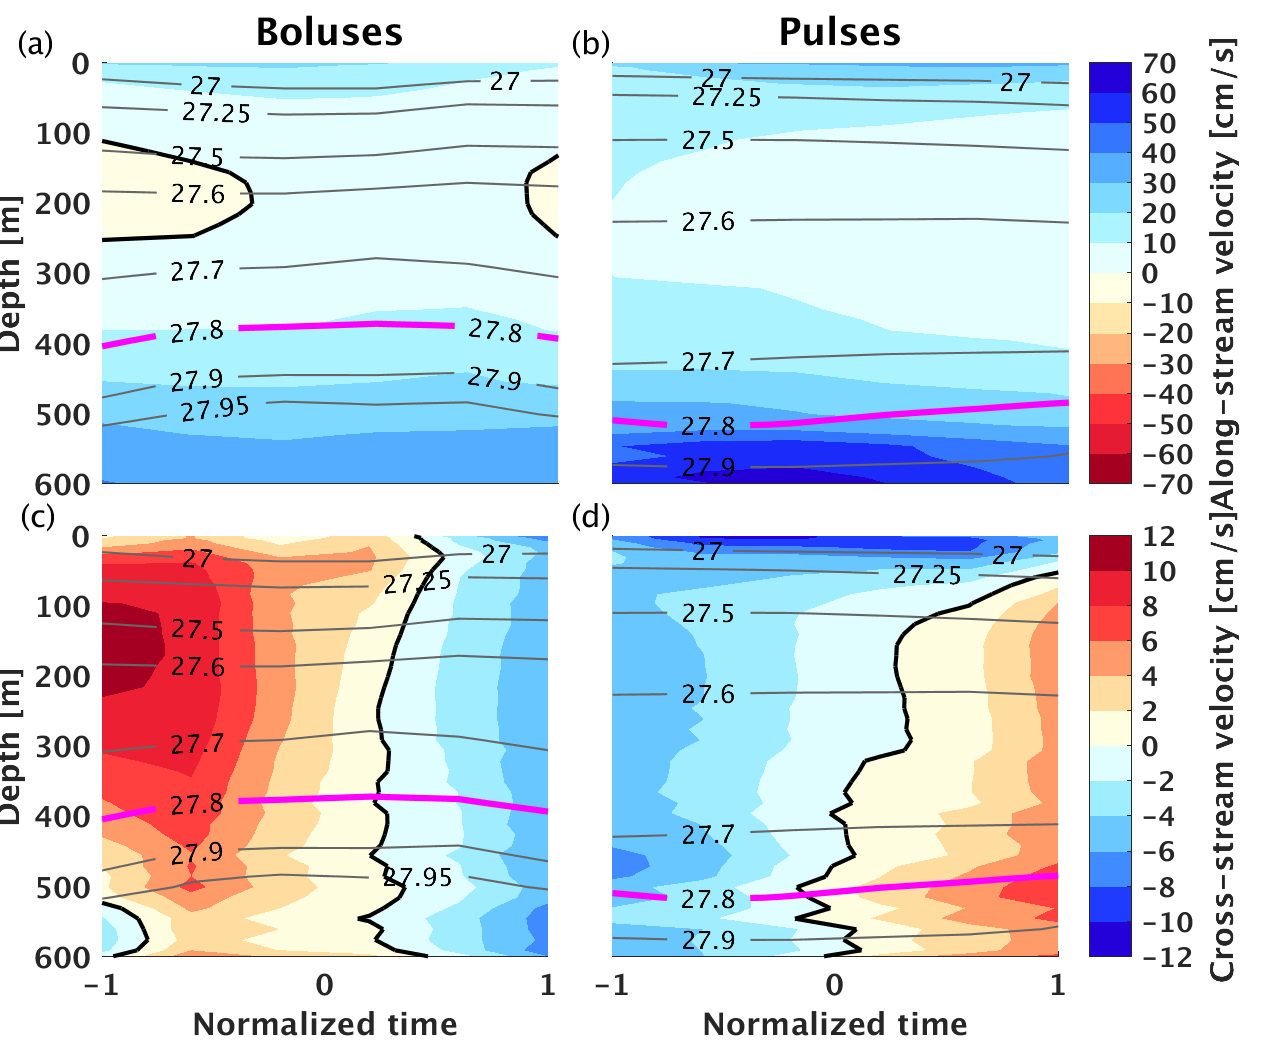

Number of boluses in the composite: 13
 Number of pulses in the composite: 12


In [7]:
% Figure 10
% ==================================================================================================
% Same as Fig. 09 except for (a and b) along-stream velocity, and (c and d) cross-stream velocity. 
% The along-stream direction for boluses and pulses is defined as 
% the orientation of the mean velocity vectors in Fig.~\ref{fig:direction_DSO}. 
% Zero-velocity contours are drawn in black.
% ==================================================================================================

% Housekeeping
clearvars -except path_matfiles

% Load variables and mask
load([path_matfiles '/mask_BolPol'])
load([path_matfiles '/Sigma0_Latrabjarg.mat'])
load([path_matfiles '/OrtVel_Latrabjarg'])
load([path_matfiles '/TanVel_Latrabjarg'])

% Grid info
DIST   = Sigma0.DIST;
TIME   = Sigma0.TIME;
DEPTH  = Sigma0.DEPTH;
bathy  = Sigma0.bathy;

% Move 0 to sill
[~,indsill] = max(bathy);
DIST = DIST - DIST(indsill);

% Average between -15 15km
dst1 = -15; dst2 = 15;
Sigma0 = squeeze(nanmean(Sigma0.values(DIST>dst1 & DIST<dst2,:,:),1));
OrtVel = squeeze(nanmean(OrtVel.values(DIST>dst1 & DIST<dst2,:,:),1));
TanVel = squeeze(nanmean(TanVel.values(DIST>dst1 & DIST<dst2,:,:),1));

% Normalized time
k = 2; newtime = linspace(-1,1,3*k);

% -------------------------------------
% Create composite of boluses
Sigma0_comp = [];
OrtVel_comp   = [];
TanVel_comp   = [];

% Exclude boluses too long/short
LIM1 = 8; LIM2 = 11;
suminds = inds_Bol(:,2)-inds_Bol(:,1);
inds_Bol(suminds<LIM1 | suminds>LIM2,:) = [];
for i = 1:size(inds_Bol,1)

        thisinds = inds_Bol(i,1):inds_Bol(i,2);
        thistime = TIME(thisinds);
        dt       = thistime(end) - thistime(1);
        thistime = (thistime - thistime(1) - dt/2);
        thistime = thistime/max(thistime);

        sigma0  = Sigma0(:,thisinds);
        ortvel  = OrtVel(:,thisinds);
        tanvel  = TanVel(:,thisinds);

        newsigma0 = interp2(DEPTH,thistime,sigma0',DEPTH,newtime);
        newortvel = interp2(DEPTH,thistime,ortvel',DEPTH,newtime);
        newtanvel = interp2(DEPTH,thistime,tanvel',DEPTH,newtime);

        Sigma0_comp(:,:,i) = newsigma0;
        OrtVel_comp(:,:,i)   = newortvel;
        TanVel_comp(:,:,i)   = newtanvel;
end
fprintf('\n Number of boluses in the composite: %d',size(inds_Bol,1));
Sigma0_bol = nanmean(Sigma0_comp,3);
OrtVel_bol = nanmean(OrtVel_comp,3);
TanVel_bol = nanmean(TanVel_comp,3);

% -------------------------------------
% Create composite of pulses
Sigma0_comp = [];
OrtVel_comp = [];
TanVel_comp = [];

count = 0;
for i = 1:size(inds_Pul,1)
        thisinds = inds_Pul(i,1):inds_Pul(i,2);
        thistime = TIME(thisinds);
        dt       = thistime(end) - thistime(1);
        thistime  = (thistime - thistime(1) - dt/2);
        thistime  = thistime/max(thistime);

        sigma0  = Sigma0(:,thisinds);
        ortvel  = OrtVel(:,thisinds);
        tanvel  = TanVel(:,thisinds);

        newsigma0 = interp2(DEPTH,thistime,sigma0',DEPTH,newtime);
        newortvel = interp2(DEPTH,thistime,ortvel',DEPTH,newtime);
        newtanvel = interp2(DEPTH,thistime,tanvel',DEPTH,newtime);

        indDEPTH = min(find(DEPTH>550));
        thisnewortvel = nanmean(newortvel(:,indDEPTH:end),2);
        thisnewtanvel = nanmean(newtanvel(:,indDEPTH:end),2);

        % Consider only symmetric pulses
        if mean(thisnewortvel(1:k))>mean(thisnewortvel(k+1:2*k)) & mean(thisnewortvel(2*k+1:end))>mean(thisnewortvel(k+1:2*k))
                count = count+1;
                Sigma0_comp(:,:,count) = newsigma0;
                OrtVel_comp(:,:,count) = newortvel;
                TanVel_comp(:,:,count) = newtanvel;
        end
end
Sigma0_pul = nanmean(Sigma0_comp,3);
OrtVel_pul = nanmean(OrtVel_comp,3);
TanVel_pul = nanmean(TanVel_comp,3);
fprintf('\n Number of pulses in the composite: %d\n',count);

% Rotate along and cross-stream velocities
dir = -124; % <---- This direction has been computed in F07
Ang  = 180-dir+90;
U = TanVel_pul;
V = OrtVel_pul;
Astream_pul = U.*cosd(Ang) - V.*sind(Ang);
Cstream_pul = V.*cosd(Ang) + U.*sind(Ang);
clear dir ang Ang U V

dir = -109; % <---- This direction has been computed in F07
Ang  = 180-dir+90;
U = TanVel_bol;
V = OrtVel_bol;
Astream_bol = U.*cosd(Ang) - V.*sind(Ang);
Cstream_bol = V.*cosd(Ang) + U.*sind(Ang);
clear dir ang Ang U V

% FIGURE
fig    = figure();
set(fig,'Position', [0, 0, 850, 700]./1.e2)
set(0,'DefaultAxesFontSize',14)
positionSubplot = [0.08  0.54  0.44 0.4 ;
                   0.48  0.54  0.44 0.4 ;
                   0.08  0.09  0.44 0.4 ;
                   0.48  0.09  0.44 0.4];
% Subplots
X = newtime;
Y = DEPTH;

for i=1:size(positionSubplot,1)
        ax(i) = subplot('Position',positionSubplot(i,:));
        hold on
        switch i
                case 1
                        ticks = [-70:10:70];
                        Z     = Cstream_bol;
                        thisSigma0 = Sigma0_bol;
                        lab   = 'Along-stream velocity [cm/s]';
                        tit   = 'Boluses';
                case 2
                        Z     = Cstream_pul;
                        thisSigma0 = Sigma0_pul;
                        lab   = 'Along-stream velocity [cm/s]';
                        tit   = 'Pulses';
                case 3
                        ticks = [-12:2:12];
                        Z     = Astream_bol;
                        thisSigma0 = Sigma0_bol;
                        lab   = 'Cross-stream velocity [cm/s]';
                        tit   = 'Boluses';
                case 4
                        Z     = Astream_pul;
                        thisSigma0 = Sigma0_pul;
                        lab   = 'Cross-stream velocity [cm/s]';
                        tit   = 'Pulses';
        end
        Z = Z.*1.e2; %cm/s

        % Contour
        if i==1 | i==2
                Z = -Z; % For simplicity soutward = positive in the manuscript
                colormap(ax(i),flipud(othercolor('BuDRd_18',length(ticks)-1)))
        else
                colormap(ax(i),othercolor('BuDRd_18',length(ticks)-1))
        end
        contourf(X,Y,inpaint_nans(Z'),ticks,'LineColor','none')
        caxis([min(ticks) max(ticks)])
        colbh = colorbar();

        if i==1 | i==3
                set(colbh,'Visible','off')
                ylabel('Depth [m]','FontWeight','bold','FontSize',15)
        else
                set(gca,'ytick',[])
                set(colbh,'FontSize',13,'YTick',ticks)
                ylabel(colbh,lab,'FontWeight','bold','FontSize',15)
        end
        if i>=3
                xlabel('Normalized time','FontWeight','bold','FontSize',15)
        else
                title(tit,'FontWeight','bold','FontSize',18)
                set(gca,'xtick',[])
        end

        % 0 Vel contour
        contour(X,Y,inpaint_nans(Z)',[0 0],'k','LineWidth',2)

        % Density
        ticksDen = [26.5 27 27.25 27.5 27.6 27.7 27.9 27.95 28];
        [C,h2]   = contour(X,Y,inpaint_nans(thisSigma0'),ticksDen,'Color',[0.4 0.4 0.4],'LineWidth',1);
        clabel(C,h2,'FontSize',12)
        [C,h3]   = contour(X,Y,inpaint_nans(thisSigma0'),[27.8 27.8],'m','LineWidth',3);
        clabel(C,h3,'FontSize',12)

        % Axis
        ylim([0 600])
        set(gca,'Ydir','reverse')
        if i==2 | i==4
                text(-1,0,['(' char('a'+i-1) ')'],'FontSize',15,'HorizontalAlignment','right','VerticalAlignment','bottom')
        else
                text(-1.2,0,['(' char('a'+i-1) ')'],'FontSize',15,'HorizontalAlignment','right','VerticalAlignment','bottom')
        end
end


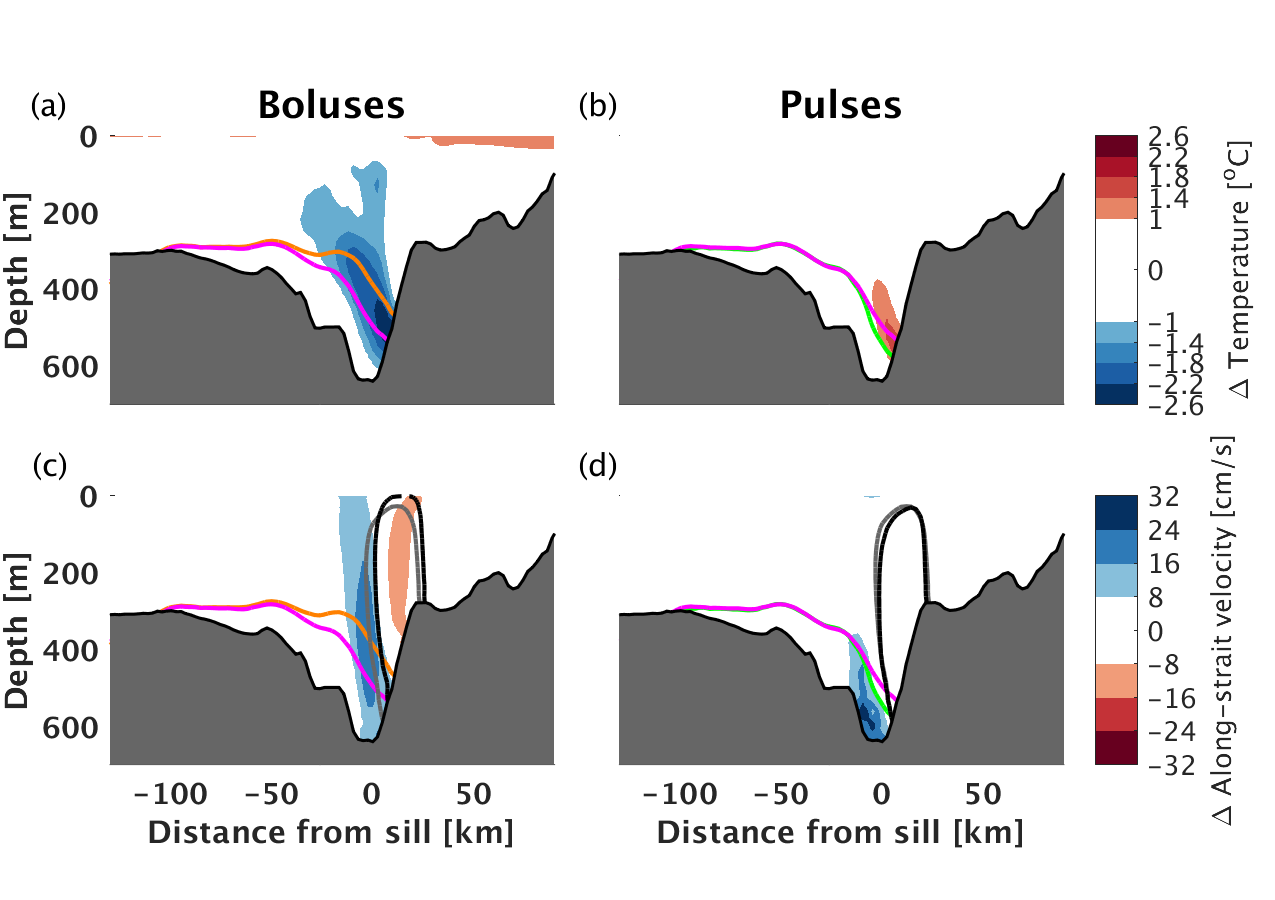

In [8]:
% Figure 11
% =========================================================================================================
% Composites of boluses (left column) and pulses (right column) minus the background state:
% (a and b) potential temperature, and (c and d) along-strait velocity. 
% Positive velocities are equatorward. 
% The DSO interface during boluses (orange), pulses (green), and background state (magenta) are outlined. 
% Gray contours bound the northward flow at the Iceland shelfbreak during the background state, 
% while black contours bound the northward flow during boluses in (c) and pulses in (d).
% =========================================================================================================

% Housekeeping
clearvars -except path_matfiles

% Load variables and mask
load([path_matfiles '/mask_BolPol'])
load([path_matfiles '/Sigma0_Latrabjarg.mat'])
load([path_matfiles '/OrtVel_Latrabjarg'])
load([path_matfiles '/Temp_Latrabjarg'])

% Create dimensions
X           = Temp.DIST;
Y           = Temp.DEPTH;
bathy       = Temp.bathy;

% Move 0 to sill
[~,indsill] = max(bathy);
X = X - X(indsill);

% Create composites
Temp_bol    = squeeze(nanmean(Temp.values(:,:,msk_Bol),3));
Temp_pul    = squeeze(nanmean(Temp.values(:,:,msk_Pul),3));
Temp_bgd    = squeeze(nanmean(Temp.values(:,:,msk_Bgd),3));
OrtVel_bol  = squeeze(nanmean(OrtVel.values(:,:,msk_Bol),3));
OrtVel_pul  = squeeze(nanmean(OrtVel.values(:,:,msk_Pul),3));
OrtVel_bgd  = squeeze(nanmean(OrtVel.values(:,:,msk_Bgd),3));
Sigma0_bol  = squeeze(nanmean(Sigma0.values(:,:,msk_Bol),3));
Sigma0_pul  = squeeze(nanmean(Sigma0.values(:,:,msk_Pul),3));
Sigma0_bgd  = squeeze(nanmean(Sigma0.values(:,:,msk_Bgd),3));

% Figure
fig    = figure();
set(fig,'Position',[0, 0, 850, 600]./1.e2);
set(0,'DefaultAxesFontSize',14)
positionSubplot = [0.06  0.55  0.4 0.3 ;
                   0.46  0.55  0.4 0.3 ;
                   0.06  0.15  0.4 0.3 ;
                   0.46  0.15  0.4 0.3];
colpul = [0 1 0];
colbol = [1 0.5 0];

% Initialize bathy
x1 = X';
y1 = bathy';
x2 = x1;
y2 = repmat(700,size(x2));

% Subplots
for i=1:size(positionSubplot,1)

        ax(i) = subplot('Position',positionSubplot(i,:));
        positionAxes = get(gca,'Position');
        hold on

        switch i
                case 1
                        field = Temp_bol-Temp_bgd;
                case 2
                        field = Temp_pul-Temp_bgd;
                case 3
                        field = OrtVel_bol-OrtVel_bgd;
                        field = field .*1.e2;
                case 4
                        field = OrtVel_pul-OrtVel_bgd;
                        field = field.*1.e2;
        end
        field = inpaint_nans(field);

        % Choose plot details
        if any(i == [1 2])
                ticks = [-2.6:0.4:2.6];
                tickslab = ticks;
                tickslab(tickslab>-1 & tickslab<1 & tickslab~=0) = [];
                tickslab = sort([tickslab 0]);
                color = flipud(othercolor('RdBu11',length(ticks)-1));
                color(5:9,:) = ones(5,3);
                long_name = '\Delta Temperature [^oC]';
        elseif any(i == [3 4])
                ticks = [-32:8:32];
                tickslab = ticks;
                tickslab(tickslab>-8 & tickslab<8 & tickslab~=0) = [];
                color = othercolor('RdBu11',length(ticks)-1);
                color(4:5,:) = ones(2,3);
                long_name = '\Delta Along-strait velocity [cm/s]';
                field = -field;
        end

        % Field
        contourf(X,Y,field',ticks,'LineColor','none');
        colormap(ax(i),color);
        colbh = colorbar();
        caxis([min(ticks) max(ticks)])

        % Density
        if any(i == [1 3])
                [C,h] = contour(X,Y,inpaint_nans(Sigma0_bol)',[27.8 27.8],'Color',colbol,'LineWidth',2);
        else
                [C,h] = contour(X,Y,inpaint_nans(Sigma0_pul)',[27.8 27.8],'Color',colpul,'LineWidth',2);
        end
        [C,h] = contour(X,Y,inpaint_nans(Sigma0_bgd)',[27.8 27.8],'Color','m','LineWidth',2);

        % Zero contours velocities
        xa = -5;
        xb = 30;
        switch i
                case 3
                        contour(X(X>xa & X<xb),Y,inpaint_nans(OrtVel_bgd(X>xa & X<xb,:))',[0 0],'Color',[0.4 0.4 0.4],'LineWidth',2);
                        contour(X(X>xa & X<xb),Y,inpaint_nans(OrtVel_bol(X>xa & X<xb,:))',[0 0],'Color','k','LineWidth',2);
                case 4
                        contour(X(X>xa & X<xb),Y,inpaint_nans(OrtVel_bgd(X>xa & X<xb,:))',[0 0],'Color',[0.4 0.4 0.4],'LineWidth',2);
                        contour(X(X>xa & X<xb),Y,inpaint_nans(OrtVel_pul(X>xa & X<xb,:))',[0 0],'Color','k','LineWidth',2);
        end

        % Bathymetry
        fill([x1,fliplr(x2)],[y1,fliplr(y2)],[0.4 0.4 0.4],'edgecolor',[0.4 0.4 0.4]);
        plot(x1,y1,'k-','LineWidth',1.5);

        % Text
        txt = {'(a)' '(b)' '(c)' '(d)' '(d)'};
        if any(i == [1 3])
                set(colbh,'Visible','off')
                set(gca,'Position',positionAxes)
                ylabel('Depth [m]','FontWeight','bold')
                text(-150,-30,txt{i},'FontSize',15,'HorizontalAlignment','right','VerticalAlignment','bottom');
        else

                ylabel(colbh,long_name,'FontWeight','bold','FontSize',13)
                set(colbh,'YTick',tickslab)
                colPos = get(colbh,'Position');
                colPos(1) = 0.86;
                set(colbh,'Position',colPos)
                set(colbh,'FontWeight','normal','FontSize',13)
                set(gca,'Position',positionAxes)
                set(gca,'Ytick',[]);
                text(-130,-30,txt{i},'FontSize',15,'HorizontalAlignment','right','VerticalAlignment','bottom');
        end
        if any(i== [3 4])
                xlabel('Distance from sill [km]','FontWeight','bold')
        else
                set(gca,'Xtick',[]);
        end

        if i==1
                title('Boluses','FontSize',18,'FontWeight','bold')
        elseif i==2
                title('Pulses','FontSize',18,'FontWeight','bold')
        end
        ylim([0 700])
        xlim([-130 90])
        set(gca,'Ydir','reverse')
        daspect([0.19 1 1])
end


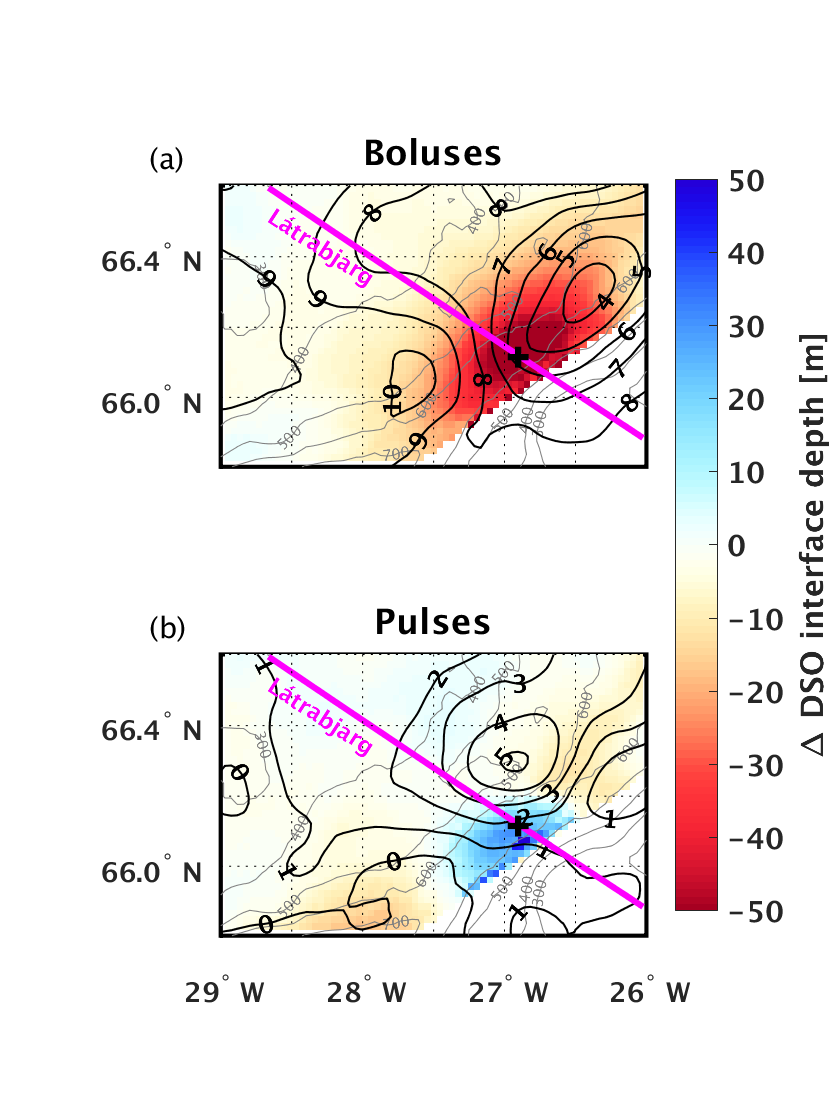

Maximum interface displacement:
        BOLUSES: [-86.459537] m
        PULSES: [51.857849] m


In [9]:
% Figure 12
% ======================================================================================
% Composite of DSO interface during (a) boluses and (b) pulses minus the background state. 
% Black contour lines show the SSH composite during (a) boluses and 
% (b) pulses minus the background state (cm). 
% The bathymetric contours are shown in gray (m). 
% The L\'atrabjarg line is drawn in magenta, and the black cross corresponds to the sill. 
% Regions where the entire water column can be lighter than overflow water are masked white. 
% Negative (positive) anomalies correspond to a shallower (deeper) DSO compared to the background state.
% ======================================================================================

% Housekeeping
clearvars -except path_matfiles

% Load variables and mask
load([path_matfiles '/mask_BolPol'])
load([path_matfiles '/Sigma0_Cube.mat'])
load([path_matfiles '/Eta_Cube.mat'])
load([path_matfiles '/Temp_Latrabjarg'])

% Create composites
Sigma0_bol  = squeeze(mean(Sigma0_Cube.values(:,:,:,msk_Bol),4));
Sigma0_pul  = squeeze(mean(Sigma0_Cube.values(:,:,:,msk_Pul),4));
Sigma0_bgd  = squeeze(mean(Sigma0_Cube.values(:,:,:,msk_Bgd),4));
Eta_bol     = squeeze(nanmean(Eta_Cube.values(:,:,:,msk_Bol),4));
Eta_pul     = squeeze(nanmean(Eta_Cube.values(:,:,:,msk_Pul),4));
Eta_bgd     = squeeze(nanmean(Eta_Cube.values(:,:,:,msk_Bgd),4));

% Create dimensions
LON = Sigma0_Cube.LON;
LAT = Sigma0_Cube.LAT;
DEPTH = Sigma0_Cube.DEPTH;
bathy = Sigma0_Cube.bathy;
[LON3,LAT3,DEPTH3] = meshgrid(LON,LAT,DEPTH);
[LON2,LAT2] = meshgrid(LON,LAT);

% Map of DSO interface depth
lbl = {'bol' 'bgd' 'pul'};
for i=1:length(lbl)

        % Pick composite
        eval(['my_array = Sigma0_' lbl{i} ';']);
        my_array = permute(my_array,[2 1 3]);

        % Find isosurface DSO
        p = isosurface(LON3,LAT3,DEPTH3,my_array,27.8);
        x = p.vertices(:,1);
        y = p.vertices(:,2);
        z = p.vertices(:,3);

        % Re-grid to 2D arrays
        warning('off','MATLAB:scatteredInterpolant:DupPtsAvValuesWarnId')
        DEPTH2 = griddata(x,y,z,LON2,LAT2);
        warning('on','MATLAB:scatteredInterpolant:DupPtsAvValuesWarnId')

        % Store composite
        DEPTH2 = DEPTH2';
        eval(['OWdepth_' lbl{i} '= DEPTH2;']);
end

% Sill
lonsill = -26.9041;
latsill =  66.1149;

% Latrabjarg Line
x1 = -29.8; x2 = -24.6;
y1 =  66.9; y2 =  65.5;
coefficients = polyfit([x1, x2], [y1, y2], 1);
a = coefficients (1);
b = coefficients (2);
XLAT = LON;
YLAT = a*XLAT+b;
XLat = XLAT(XLAT<-26 & XLAT>-29 & YLAT<66.6 & YLAT>65.8);
YLat = YLAT(XLAT<-26 & XLAT>-29 & YLAT<66.6 & YLAT>65.8);

% Figure
fig = figure();
set(fig,'units','normalized','outerposition',[0 0 0.4 0.8])
colormap(fig,flipud(othercolor('BuDRd_18',100)));
set(0,'DefaultAxesFontSize',15)

% subplots
I = [1:5;6:10];
for i = 1:2
        ax(i) = subplot(10,1,I(i,:));
        hold on
        axis off
        if i==1
                ax1 = axesm(  'MapProjection','mercator',...
                        'MapLatLimit',[65.8 66.6],...
                        'MapLonLimit',[-29 -26],...
                        'Frame','on',...
                        'FFill',0,...
                        'FEdgeColor',[0 0 0],...
                        'FFaceColor',[1 1 1],...
                        'Grid','on',...
                        'MLineLocation',[-29:0.5:-26],...
                        'PLineLocation',[65.8:0.2:66.6],...
                        'GColor',[0 0 0],...
                        'GLineStyle',':',...
                        'GLineWidth',0.5,...
                        'FontSize',13,...
                        'FontWeight','bold',...
                        'LabelFormat','compass',...
                        'MeridianLabel','on',...
                        'MLabelLocation',100,...
                        'ParallelLabel','on',...
                        'PLabelLocation',0.4,...
                        'PLabelRound',-1);
        else
                ax2 = axesm(  'MapProjection','mercator',...
                        'MapLatLimit',[65.8 66.6],...
                        'MapLonLimit',[-29 -26],...
                        'Frame','on',...
                        'FFill',0,...
                        'FEdgeColor',[0 0 0],...
                        'FFaceColor',[1 1 1],...
                        'Grid','on',...
                        'MLineLocation',[-29:0.5:-26],...
                        'PLineLocation',[65.8:0.2:66.6],...
                        'GColor',[0 0 0],...
                        'GLineStyle',':',...
                        'GLineWidth',0.5,...
                        'FontSize',13,...
                        'FontWeight','bold',...
                        'LabelFormat','compass',...
                        'MeridianLabel','on',...
                        'MLabelLocation',1,...
                        'ParallelLabel','on',...
                        'PLabelLocation',0.4,...
                        'PLabelRound',-1,...
                        'MLabelParallel','south');
        end
        if i == 1
                Z = [OWdepth_bol-OWdepth_bgd];
                E = [Eta_bol-Eta_bgd];
                tit = title('Boluses');
        else
                Z = [OWdepth_pul-OWdepth_bgd];
                E = [Eta_pul-Eta_bgd];
                tit = title('Pulses');
        end
        E = E.*10^2; % cm
        PosTit = get(tit,'Position');
        PosTit(2) = PosTit(2)-0.005;
        set(tit,'Position',PosTit)

        % Plot displacement interface
        pcolorm(LAT,LON,Z');
        caxis([-50 50])
        colbh = colorbar();
        if i == 1
                Pos_colbh1 = get(colbh,'Position');
                delete(colbh)
        else
                Pos_colbh2 = get(colbh,'Position');
                Pos_colbh2(4) = Pos_colbh1(2) + Pos_colbh1(4) - Pos_colbh2(2);
                set(colbh,'Position',Pos_colbh2)
                ylabel(colbh,'\Delta DSO interface depth [m]','FontWeight','bold','FontSize',15)
        end
        % Bathymetry
        [C,h] = contourm(LAT,LON,bathy',[0:100:700],'Color',[0.5 0.5 0.5]);
        hText = clabelm(C,h);
        set(hText,'FontSize',7,'BackgroundColor','none','Color',[0.5 0.5 0.5])

        % Eta
        [C,h] = contourm(LAT,LON,E',[0:10],'Color',[0 0 0],'LineWidth',1);
        hText = clabelm(C,h);
        set(hText,'FontSize',12,'BackgroundColor','none','FontWeight','bold')

        % Latrabjarg
        plotm(YLat,XLat,'m-','LineWidth',3)
        textm(66.52,-28.65,'Látrabjarg','FontSize',11,'FontWeight','bold','rotation',-33,'Color','m');

        % Sill
        plotm(latsill,lonsill,'k+','MarkerSize',10,'LineWidth',3)

        % Label plot
        xl = get(gca,'XLim');
        yl = get(gca,'Ylim');
        text(xl(1)+0.005,yl(2)-0.002,['(' char('a'+i-1) ')'],'FontSize',14)

        if i ==1
                fprintf('\n Maximum interface displacement:')
                fprintf('\n        BOLUSES: [%f] m', min(Z(:)));
        else
                fprintf('\n        PULSES: [%f] m', max(Z(:)));
        end
end
